In [1]:
%matplotlib inline


# Ensemble verification

In this tutorial we perform a verification of a probabilistic extrapolation nowcast 
using MeteoSwiss radar data.


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pysteps import io, nowcasts, rcparams, verification
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing import ensemblestats
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read precipitation field

First, we will import the sequence of MeteoSwiss ("mch") radar composites.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201607112100", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]
n_ens_members = 20
n_leadtimes = 6
seed = 24

### Load the data from the archive

The data are upscaled to 2 km resolution to limit the memory usage and thus
be able to afford a larger number of ensemble members.



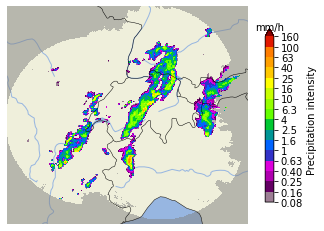

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -10.0,
 'timestamps': array([datetime.datetime(2016, 7, 11, 20, 50),
       datetime.datetime(2016, 7, 11, 20, 55),
       datetime.datetime(2016, 7, 11, 21, 0)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 255000.0,
 'x2': 965000.0,
 'xpixelsize': 2000,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 2000,
 'zerovalue': -15.0,
 'zr_a': 316.0,
 'zr_b': 1.5}


In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Find the radar files in the archive
fns = io.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=2
)

# Read the data from the archive
importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)

# Upscale data to 2 km
R, metadata = dimension.aggregate_fields_space(R, metadata, 2000)

# Plot the rainfall field
plot_precip_field(R[-1, :, :], geodata=metadata)
plt.show()

# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,
# set the fill value to -15 dBR
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Set missing values with the fill value
R[~np.isfinite(R)] = -15.0

# Nicely print the metadata
pprint(metadata)

## Forecast

We use the STEPS approach to produce a ensemble nowcast of precipitation fields.



Computing STEPS nowcast:
------------------------

Inputs:
-------
input dimensions: 320x355
km/pixel:         2
time step:        5 minutes

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     6
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-------------------------------------

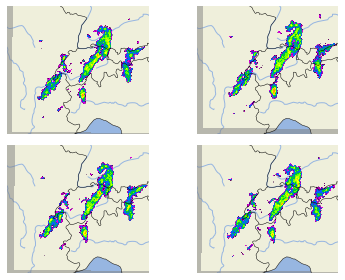

In [5]:
# Estimate the motion field
V = dense_lucaskanade(R)

# Perform the ensemble nowcast with STEPS
nowcast_method = nowcasts.get_method("steps")
R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels=6,
    R_thr=-10.0,
    kmperpixel=2.0,
    timestep=timestep,
    decomp_method="fft",
    bandpass_filter_method="gaussian",
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
)

# Back-transform to rain rates
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]

# Plot some of the realizations
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.set_title("Member %02d" % i)
    plot_precip_field(R_f[i, -1, :, :], geodata=metadata, colorbar=False, axis="off")
plt.tight_layout()
plt.show()

## Verification

Pysteps includes a number of verification metrics to help users to analyze
the general characteristics of the nowcasts in terms of consistency and
quality (or goodness).
Here, we will verify our probabilistic forecasts using the ROC curve,
reliability diagrams, and rank histograms, as implemented in the verification
module of pysteps.



In [6]:
# Find the files containing the verifying observations
fns = io.archive.find_by_date(
    date,
    root_path,
    path_fmt,
    fn_pattern,
    fn_ext,
    timestep,
    0,
    num_next_files=n_leadtimes,
)

# Read the observations
R_o, _, metadata_o = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to mm/h
R_o, metadata_o = conversion.to_rainrate(R_o, metadata_o)

# Upscale data to 2 km
R_o, metadata_o = dimension.aggregate_fields_space(R_o, metadata_o, 2000)

# Compute the verification for the last lead time

# compute the exceedance probability of 0.1 mm/h from the ensemble
P_f = ensemblestats.excprob(R_f[:, -1, :, :], 0.1, ignore_nan=True)

### ROC curve



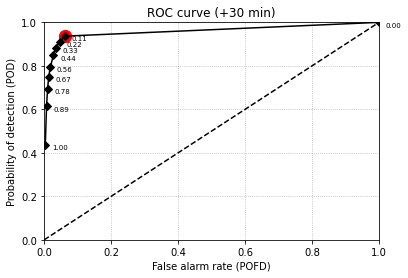

In [7]:
roc = verification.ROC_curve_init(0.1, n_prob_thrs=10)
verification.ROC_curve_accum(roc, P_f, R_o[-1, :, :])
fig, ax = plt.subplots()
verification.plot_ROC(roc, ax, opt_prob_thr=True)
ax.set_title("ROC curve (+%i min)" % (n_leadtimes * timestep))
plt.show()

### Reliability diagram



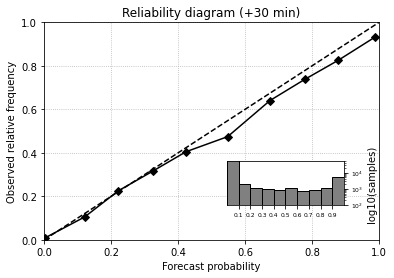

In [8]:
reldiag = verification.reldiag_init(0.1)
verification.reldiag_accum(reldiag, P_f, R_o[-1, :, :])
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+%i min)" % (n_leadtimes * timestep))
plt.show()

### Rank histogram



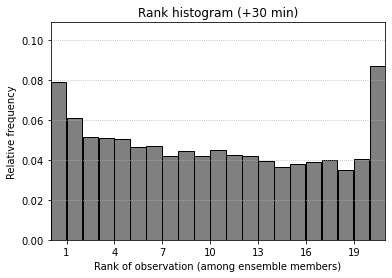

In [9]:
rankhist = verification.rankhist_init(R_f.shape[0], 0.1)
verification.rankhist_accum(rankhist, R_f[:, -1, :, :], R_o[-1, :, :])
fig, ax = plt.subplots()
verification.plot_rankhist(rankhist, ax)
ax.set_title("Rank histogram (+%i min)" % (n_leadtimes * timestep))
plt.show()

# sphinx_gallery_thumbnail_number = 5